In [14]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/sample_submission.csv


In [15]:
import pandas as pd
import numpy as np
from catboost import Pool, CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))
import re
from nltk.tokenize import word_tokenize
import gensim
import string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

In [16]:
import os
tweet= pd.read_csv('../input/nlp-getting-started/train.csv')
test=pd.read_csv('../input/nlp-getting-started/test.csv')
tweet.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [17]:
tweet.keyword.value_counts()

fatalities               45
armageddon               42
deluge                   42
sinking                  41
body%20bags              41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [18]:
tweet.location.value_counts()

USA                            104
New York                        71
United States                   50
London                          45
Canada                          29
                              ... 
IG : Sincerely_TSUNAMI           1
not so cool KY                   1
Bartholomew County, Indiana      1
kediri,,jawa timur               1
Pontevedra, Galicia              1
Name: location, Length: 3341, dtype: int64

Text(0, 0.5, 'samples')

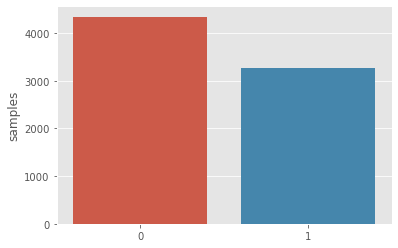

In [19]:
x=tweet.target.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('samples')

In [20]:

cat_features = ['keyword','location']
text_features = ['text']


In [21]:
tweet.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [22]:
tweet['keyword'].value_counts()

fatalities               45
armageddon               42
deluge                   42
sinking                  41
body%20bags              41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [23]:
tweet['keyword'] = np.where(tweet['keyword'].isna()==True,'UNK',tweet['keyword'])
tweet['location'] = np.where(tweet['location'].isna()==True,'UNK',tweet['location'])

In [24]:
col = ['target','id']
X = tweet.drop(col,axis=1)
y = tweet['target']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X,y.values,test_size=0.15)

In [27]:
train_pool = Pool(
    X_train, 
    y_train, 
    cat_features=cat_features, 
    text_features=text_features, 
    feature_names=list(X_train)
)
valid_pool = Pool(
    X_test, 
    y_test,
    cat_features=cat_features, 
    text_features=text_features, 
    feature_names=list(X_train)
)

catboost_params = {
    'iterations': 10000,
    'learning_rate': 0.1,
    'eval_metric': 'Accuracy',
    'task_type': 'GPU',
    'early_stopping_rounds': 5000,
    'use_best_model': True,
    'verbose': 5000
}

model = CatBoostClassifier(**catboost_params)
model.fit(train_pool, eval_set=valid_pool)



0:	learn: 0.7654149	test: 0.7854641	best: 0.7854641 (0)	total: 28.8ms	remaining: 4m 48s
5000:	learn: 0.8567455	test: 0.7880911	best: 0.7977233 (710)	total: 3m 26s	remaining: 3m 26s
bestTest = 0.7977232925
bestIteration = 710
Shrink model to first 711 iterations.


In [28]:
from sklearn.metrics import classification_report,accuracy_score
pred = model.predict(X_test)
print(classification_report(y_test,pred))
print(accuracy_score(y_test,pred))

              precision    recall  f1-score   support

           0       0.78      0.90      0.84       655
           1       0.83      0.66      0.74       487

    accuracy                           0.80      1142
   macro avg       0.81      0.78      0.79      1142
weighted avg       0.80      0.80      0.79      1142

0.797723292469352


In [29]:
pred

array([0, 0, 0, ..., 0, 0, 0])

In [30]:
test1 = test.drop('id',axis=1)

In [31]:
test1.isna().sum()

keyword       26
location    1105
text           0
dtype: int64

In [32]:
test1['keyword'] = np.where(test1['keyword'].isna()==True,'UNK',test1['keyword'])
test1['location'] = np.where(test1['location'].isna()==True,'UNK',test1['location'])

In [33]:
pred1 = model.predict(test1)
sub = pd.read_csv('../input/nlp-getting-started/sample_submission.csv')

In [36]:
pred1.shape

(3263,)

In [34]:
sub.columns

Index(['id', 'target'], dtype='object')

In [35]:
sub.target.value_counts()

0    3263
Name: target, dtype: int64

In [37]:

sub['target'] = pred1

sub.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [38]:
sub.to_csv('submission.csv', index=False)